In [2]:
# load data, extract features
import pandas as pd

df = pd.read_csv('EODHD_adjusted_macrosnp_joined_with_metadata_wsf.csv')

keep_columns = [
    'start_date',
    'inflation_rate_at_start',
    'fed_funds_rate_at_start',
    'sp500_close_at_start',
    'sp500_sma30_centered_at_start',
    'sp500_sma50_at_start',
    'sp500_sma200_at_start',
    'sp500_above_30sma_centered',
    'sp500_above_50sma',
    'sp500_above_200sma',
    'bus_state',
    'sic_description',
    'flag_6m_price',
    'flag_3y_price',
    'flag_6m_avg',
    'flag_3y_avg'
]

final_columns = [col for col in keep_columns if col in df.columns]
df_clean = df[final_columns]

print(f"Shape after keeping selected features: {df_clean.shape}")
print("\nColumns kept:")
print(df_clean.columns.tolist())

Shape after keeping selected features: (6146, 16)

Columns kept:
['start_date', 'inflation_rate_at_start', 'fed_funds_rate_at_start', 'sp500_close_at_start', 'sp500_sma30_centered_at_start', 'sp500_sma50_at_start', 'sp500_sma200_at_start', 'sp500_above_30sma_centered', 'sp500_above_50sma', 'sp500_above_200sma', 'bus_state', 'sic_description', 'flag_6m_price', 'flag_3y_price', 'flag_6m_avg', 'flag_3y_avg']


In [3]:
# calculate success rate
success_flags = ['flag_6m_price', 'flag_3y_price', 'flag_6m_avg', 'flag_3y_avg']

print("📋 Overall IPO Success Rates:\n")

for flag in success_flags:
    total_count = df_clean[flag].count() 
    total_success = df_clean[flag].sum() 
    success_rate = total_success / total_count if total_count > 0 else 0
    print(f"{flag}: {success_rate:.2%}  (n={total_count})")


📋 Overall IPO Success Rates:

flag_6m_price: 31.32%  (n=6146)
flag_3y_price: 21.61%  (n=6146)
flag_6m_avg: 31.79%  (n=6146)
flag_3y_avg: 19.77%  (n=6146)


In [4]:
# see missing values
missing_counts = df_clean.isnull().sum()

missing_counts = missing_counts.sort_values(ascending=False)

print("📋 Missing Values Per Feature:\n")
print(missing_counts)

📋 Missing Values Per Feature:

sic_description                  469
bus_state                         35
sp500_sma30_centered_at_start     12
sp500_above_30sma_centered        12
start_date                         0
inflation_rate_at_start            0
fed_funds_rate_at_start            0
sp500_close_at_start               0
sp500_sma50_at_start               0
sp500_sma200_at_start              0
sp500_above_50sma                  0
sp500_above_200sma                 0
flag_6m_price                      0
flag_3y_price                      0
flag_6m_avg                        0
flag_3y_avg                        0
dtype: int64


In [5]:
# Cholopath map
import plotly.express as px

success_flags = ['flag_6m_price', 'flag_6m_avg', 'flag_3y_price', 'flag_3y_avg']

valid_us_states = set([
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN',
    'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV',
    'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN',
    'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'DC', 'PR'
])

df_us = df_clean[df_clean['bus_state'].isin(valid_us_states)]

for flag in success_flags:
    print(f"Building Choropleth Map for: {flag}")
    
    state_success = df_us.groupby('bus_state')[flag].agg(['count', 'sum'])
    state_success['success_rate'] = state_success['sum'] / state_success['count']
    state_success = state_success.reset_index()
    state_success.rename(columns={'bus_state': 'state'}, inplace=True)

    def generate_hover_text(row):
        text = f"State: {row['state']}<br>"
        text += f"IPO Count: {row['count']}<br>"
        text += f"Success Rate: {row['success_rate']:.2%}<br>"
        if row['count'] < 50:
            text += "(Small Sample Size)"
        return text

    state_success['hover_text'] = state_success.apply(generate_hover_text, axis=1)

    state_success['coloring_value'] = state_success.apply(
        lambda row: row['success_rate'] if row['count'] >= 50 else -1,
        axis=1
    )

    custom_colorscale = [
        [0.0, 'lightgray'], 
        [0.00001, 'rgb(237,248,251)'],
        [0.5, 'rgb(158,202,225)'],
        [1.0, 'rgb(8,48,107)']
    ]

    fig = px.choropleth(
        state_success,
        locations='state',
        locationmode="USA-states",
        color='coloring_value',
        scope="usa",
        labels={'coloring_value': 'IPO Success Rate'},
        hover_name='hover_text',
        color_continuous_scale=custom_colorscale,
        range_color=(0, 0.5)
    )

    fig.update_layout(
        title_text=f"IPO Success Rate by U.S. State ({flag})",
        title_x=0.5,
        geo=dict(bgcolor='rgba(0,0,0,0)'),
        plot_bgcolor='white',
        paper_bgcolor='white'
    )

    fig.show()



Building Choropleth Map for: flag_6m_price


Building Choropleth Map for: flag_6m_avg


Building Choropleth Map for: flag_3y_price


Building Choropleth Map for: flag_3y_avg


        count  sum  success_rate
region                          
Middle    863  205      0.237543
West     1377  313      0.227306
East     2321  471      0.202930


C:\Users\User\AppData\Local\Temp\ipykernel_21964\1969532393.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_21964\1969532393.py:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




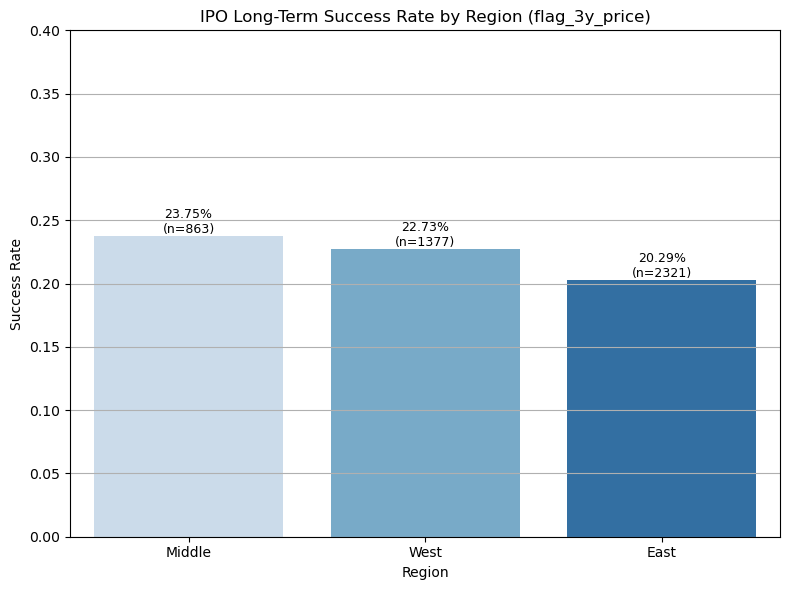

In [6]:
# west, middle, and east success rate
import seaborn as sns
import matplotlib.pyplot as plt

region_map = {
    'WA': 'West', 'OR': 'West', 'CA': 'West', 'NV': 'West', 'AZ': 'West', 'UT': 'West',
    'CO': 'West', 'ID': 'West', 'MT': 'West', 'WY': 'West', 'NM': 'West', 'AK': 'West', 'HI': 'West',

    'ND': 'Middle', 'SD': 'Middle', 'NE': 'Middle', 'KS': 'Middle', 'OK': 'Middle', 'TX': 'Middle',
    'MN': 'Middle', 'IA': 'Middle', 'MO': 'Middle', 'AR': 'Middle', 'LA': 'Middle',
    'WI': 'Middle', 'IL': 'Middle', 'IN': 'Middle', 'MI': 'Middle', 'OH': 'Middle',

    'PA': 'East', 'NY': 'East', 'NJ': 'East', 'DE': 'East', 'MD': 'East', 'DC': 'East',
    'VA': 'East', 'WV': 'East', 'NC': 'East', 'SC': 'East', 'GA': 'East', 'FL': 'East',
    'MA': 'East', 'CT': 'East', 'RI': 'East', 'VT': 'East', 'NH': 'East', 'ME': 'East',
    'TN': 'East', 'KY': 'East', 'AL': 'East', 'MS': 'East'
}

df_clean['region'] = df_clean['bus_state'].map(region_map)

df_region = df_clean[df_clean['region'].notna()]

success_flag = 'flag_3y_price'

region_success = df_region.groupby('region')[success_flag].agg(['count', 'sum'])
region_success['success_rate'] = region_success['sum'] / region_success['count']
region_success = region_success.sort_values('success_rate', ascending=False)

print(region_success)

plt.figure(figsize=(8,6))
sns.barplot(x=region_success.index, y=region_success['success_rate'], palette='Blues')
plt.title(f'IPO Long-Term Success Rate by Region ({success_flag})')
plt.xlabel('Region')
plt.ylabel('Success Rate')
plt.ylim(0, 0.4)
plt.grid(True, axis='y')

for i, p in enumerate(plt.gca().patches):
    height = p.get_height()
    count = region_success.iloc[i]['count']
    plt.text(p.get_x() + p.get_width()/2., height,
             f'{height:.2%}\n(n={int(count)})',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [28]:
# Cholopath map divided by regions
region_map = {
    'WA': 'West', 'OR': 'West', 'CA': 'West', 'AK': 'West', 'HI': 'West', 'NV': 'West', 'ID': 'West', 'UT': 'West', 'CO': 'West', 'MT': 'West', 'WY': 'West',

    'ND': 'Midwest', 'SD': 'Midwest', 'NE': 'Midwest', 'KS': 'Midwest', 'MN': 'Midwest', 'IA': 'Midwest', 'MO': 'Midwest', 'WI': 'Midwest', 'IL': 'Midwest', 'IN': 'Midwest', 'MI': 'Midwest', 'OH': 'Midwest',

    'AZ': 'Southwest', 'NM': 'Southwest', 'OK': 'Southwest', 'TX': 'Southwest',

    'AR': 'Southeast', 'LA': 'Southeast', 'MS': 'Southeast', 'AL': 'Southeast', 'GA': 'Southeast', 'SC': 'Southeast', 'NC': 'Southeast', 'FL': 'Southeast', 'TN': 'Southeast', 'KY': 'Southeast', 'WV': 'Southeast', 'VA': 'Southeast',

    'PA': 'Northeast', 'NY': 'Northeast', 'NJ': 'Northeast', 'CT': 'Northeast', 'RI': 'Northeast', 'MA': 'Northeast', 'VT': 'Northeast', 'NH': 'Northeast', 'ME': 'Northeast', 'DE': 'Northeast', 'MD': 'Northeast', 'DC': 'Northeast'
}

df_region = df[['bus_state', 'flag_3y_price']].dropna()

df_region['region'] = df_region['bus_state'].map(region_map)
df_region = df_region.dropna(subset=['region']) 

region_summary = df_region.groupby('region')['flag_3y_price'].agg(['count', 'sum']).reset_index()
region_summary['success_rate'] = region_summary['sum'] / region_summary['count']

state_to_region = pd.DataFrame(list(region_map.items()), columns=['state', 'region'])
state_data = pd.merge(state_to_region, region_summary, on='region', how='left')

fig = px.choropleth(
    state_data,
    locations='state',
    locationmode="USA-states",
    color='success_rate',
    color_continuous_scale='Blues',
    range_color=(0.18, 0.25),
    scope='usa',
    hover_name='region',
    hover_data={'success_rate': ':.2%', 'count': True, 'state': False},
    labels={'success_rate': 'Success Rate'}
)

fig.update_layout(
    title='IPO Long-Term Success Rate by Region (Grouped States)',
    title_x=0.5,
    geo=dict(bgcolor='rgba(0,0,0,0)'),
    plot_bgcolor='white',
    paper_bgcolor='white',
    margin=dict(l=0, r=0, t=50, b=0),  # Tightens whitespace
    coloraxis_colorbar=dict(
        x=0.8,         # Moves colorbar closer to the map (adjust from 0.85–0.95 as needed)
        len=0.75,      # Optional: shorten height
        thickness=20,  # Optional: narrower bar
        title='Success Rate'
    )
)

fig.show()

In [8]:
# non-US states
valid_us_states = set([
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN',
    'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV',
    'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN',
    'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'DC', 'PR'
])

invalid_states_df = df_clean[~df_clean['bus_state'].isin(valid_us_states)]

invalid_state_counts = invalid_states_df['bus_state'].value_counts()

print("⚠️ Non-U.S. State Codes and Their IPO Counts:\n")
print(invalid_state_counts)

total_invalid_ipos = invalid_states_df.shape[0]
print(f"\n🔢 Total number of non-U.S. state IPOs: {total_invalid_ipos}")



⚠️ Non-U.S. State Codes and Their IPO Counts:

bus_state
F4    332
A1    160
A6    106
L3     92
X0     90
     ... 
ct      1
S1      1
wa      1
1Z      1
Y8      1
Name: count, Length: 76, dtype: int64

🔢 Total number of non-U.S. state IPOs: 1581



📅 Analyzing flag_6m_price by Start Month and Start Year...


C:\Users\User\AppData\Local\Temp\ipykernel_21964\2980108921.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_21964\2980108921.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_21964\2980108921.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

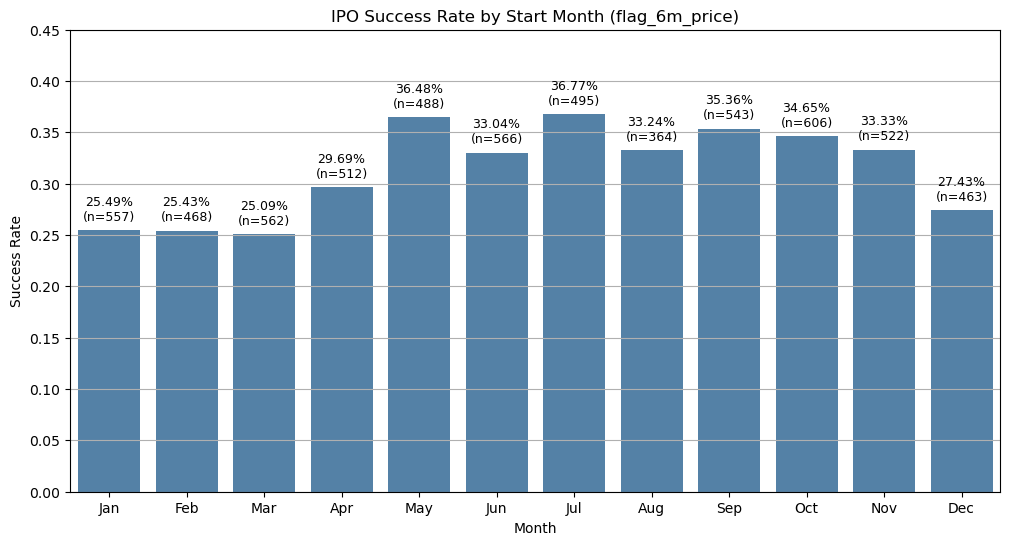

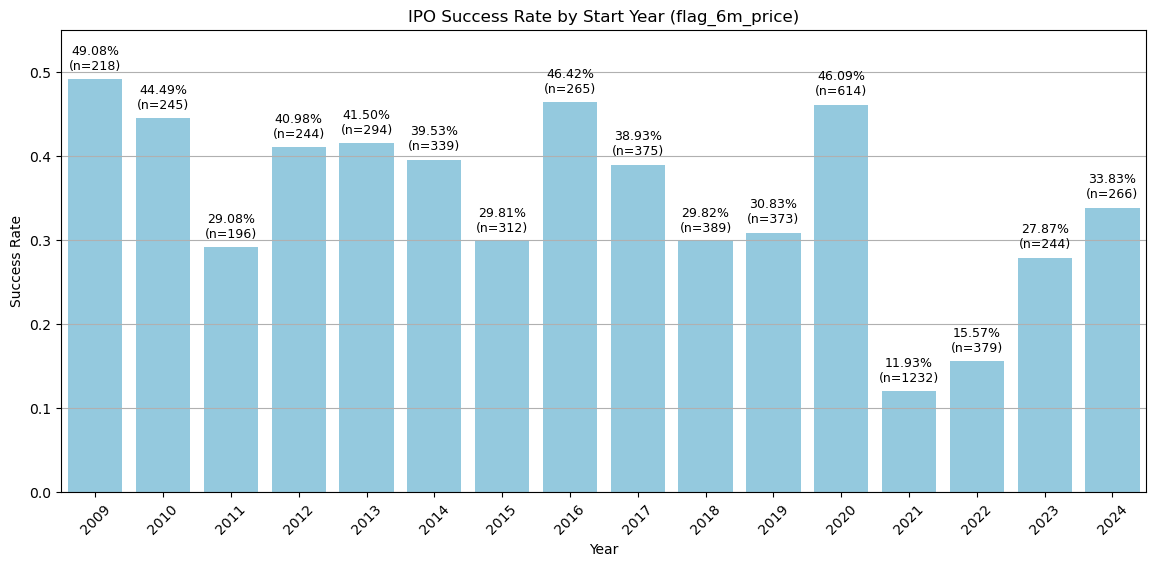


📅 Analyzing flag_6m_avg by Start Month and Start Year...


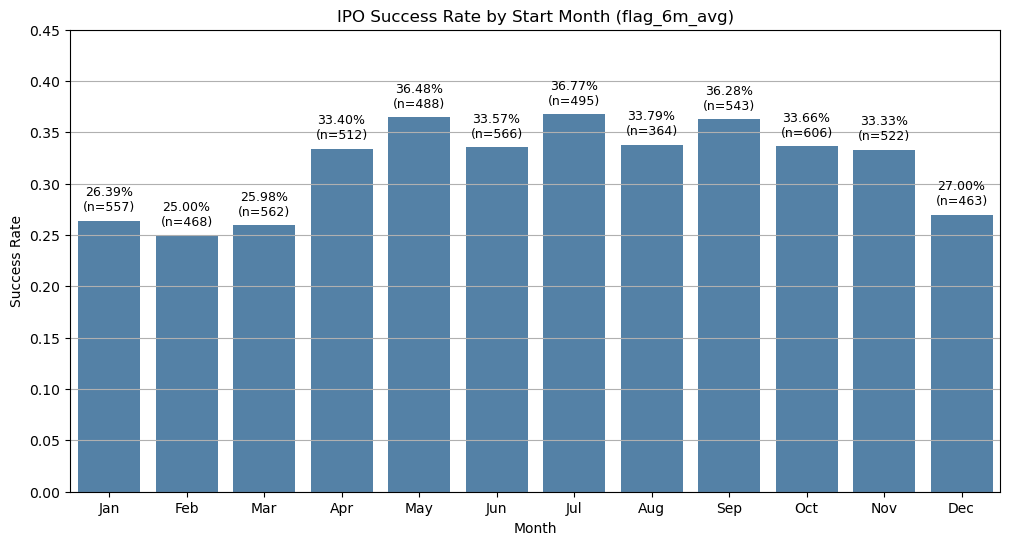

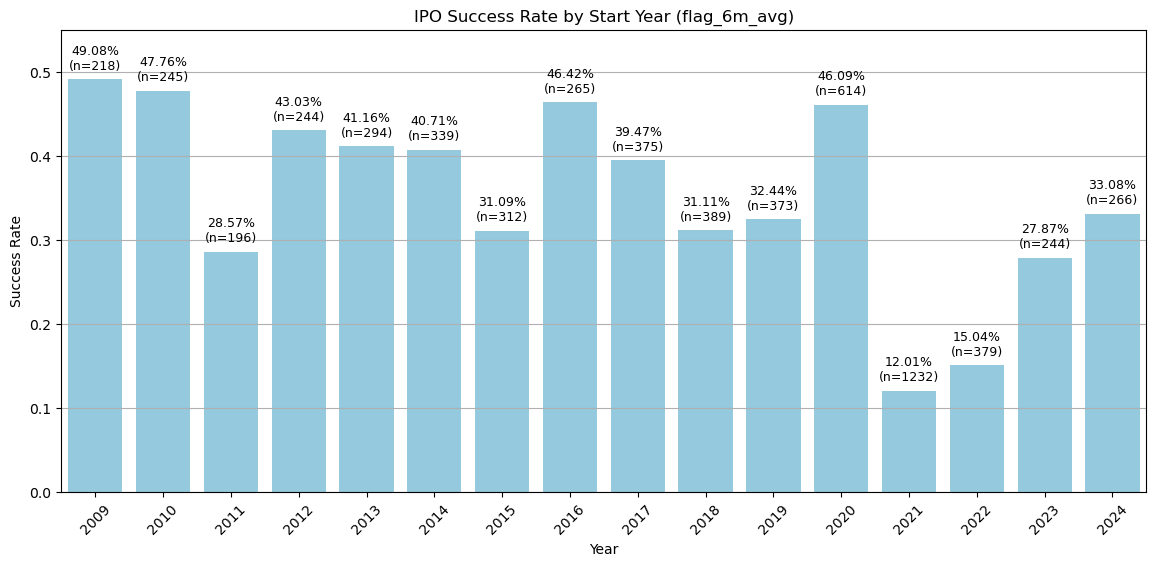

In [9]:
# success rate by month and year(6m)
from datetime import datetime, timedelta

df_clean['start_date'] = pd.to_datetime(df_clean['start_date'], errors='coerce')
df_clean['start_year'] = df_clean['start_date'].dt.year
df_clean['start_month'] = df_clean['start_date'].dt.month

today = datetime.today()
three_years_ago = today - timedelta(days=3*365)
six_months_ago = today - timedelta(days=6*30)

for flag in ['flag_6m_price', 'flag_6m_avg']:
    print(f"\n📅 Analyzing {flag} by Start Month and Start Year...")

    df_mature = df_clean[df_clean['start_date'] <= six_months_ago]

    month_success = df_clean.groupby('start_month')[flag].agg(['count', 'sum'])
    month_success['success_rate'] = month_success['sum'] / month_success['count']

    plt.figure(figsize=(12,6))
    ax = sns.barplot(x=month_success.index, y=month_success['success_rate'], color='steelblue')
    plt.title(f'IPO Success Rate by Start Month ({flag})')
    plt.xlabel('Month')
    plt.ylabel('Success Rate')
    plt.xticks(ticks=range(0,12), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    plt.ylim(0, 0.45) 
    plt.grid(True, axis='y')

    for i, p in enumerate(ax.patches):
        height = p.get_height()
        count = month_success.iloc[i]['count']
        ax.annotate(f'{height:.2%}\n(n={int(count)})',
                    (p.get_x() + p.get_width()/2., height),
                    ha='center', va='bottom', fontsize=9, color='black', xytext=(0,5),
                    textcoords='offset points')
    plt.show()

    year_success = df_mature.groupby('start_year')[flag].agg(['count', 'sum'])
    year_success['success_rate'] = year_success['sum'] / year_success['count']

    plt.figure(figsize=(14,6))
    ax = sns.barplot(x=year_success.index, y=year_success['success_rate'], color='skyblue')
    plt.title(f'IPO Success Rate by Start Year ({flag})')
    plt.xlabel('Year')
    plt.ylabel('Success Rate')
    plt.xticks(rotation=45)
    plt.ylim(0, 0.55) 
    plt.grid(True, axis='y')

    for i, p in enumerate(ax.patches):
        height = p.get_height()
        count = year_success.iloc[i]['count']
        ax.annotate(f'{height:.2%}\n(n={int(count)})',
                    (p.get_x() + p.get_width()/2., height),
                    ha='center', va='bottom', fontsize=9, color='black', xytext=(0,5),
                    textcoords='offset points')
    plt.show()


📅 Analyzing flag_3y_price by Start Month and Start Year...


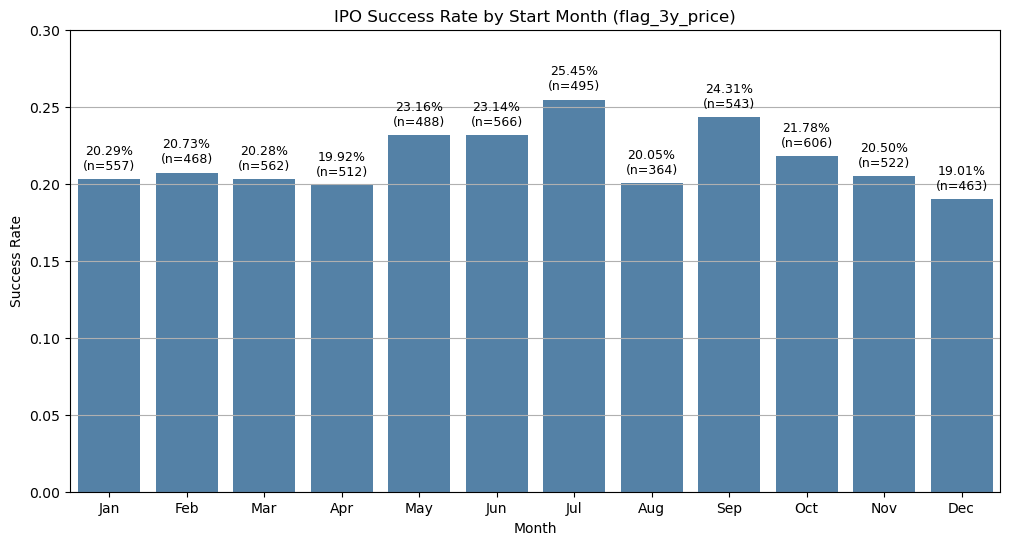

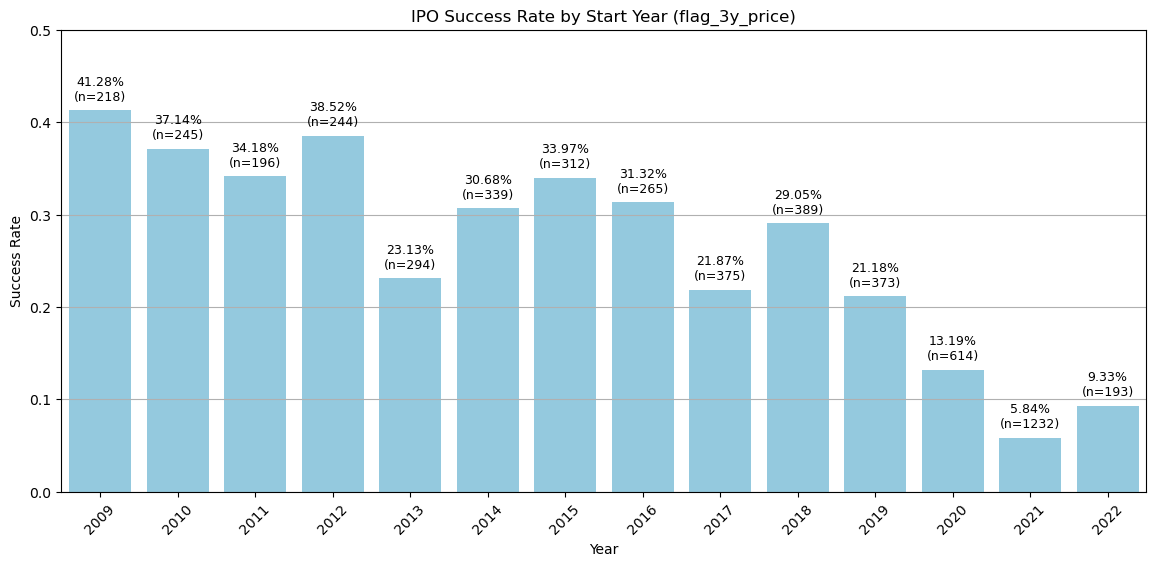


📅 Analyzing flag_3y_avg by Start Month and Start Year...


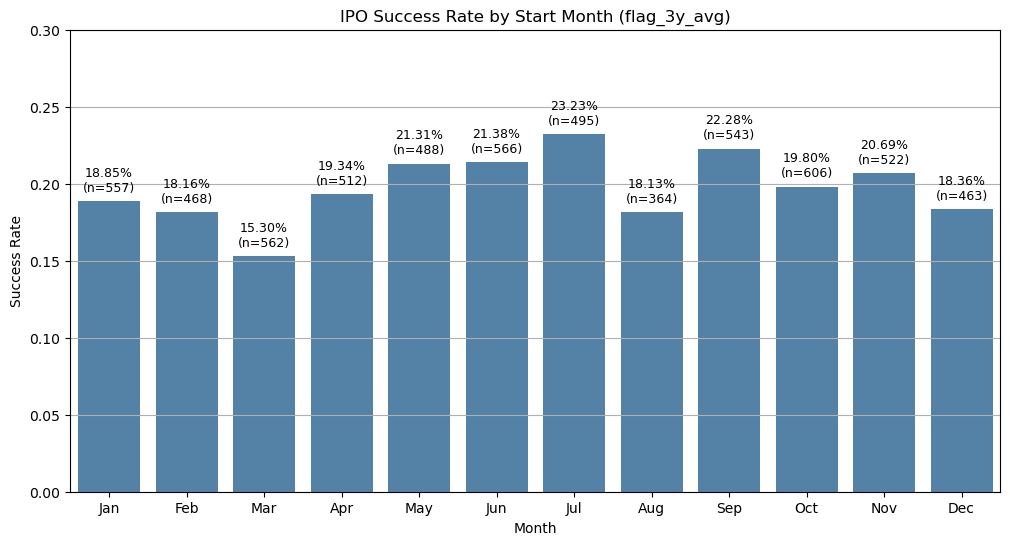

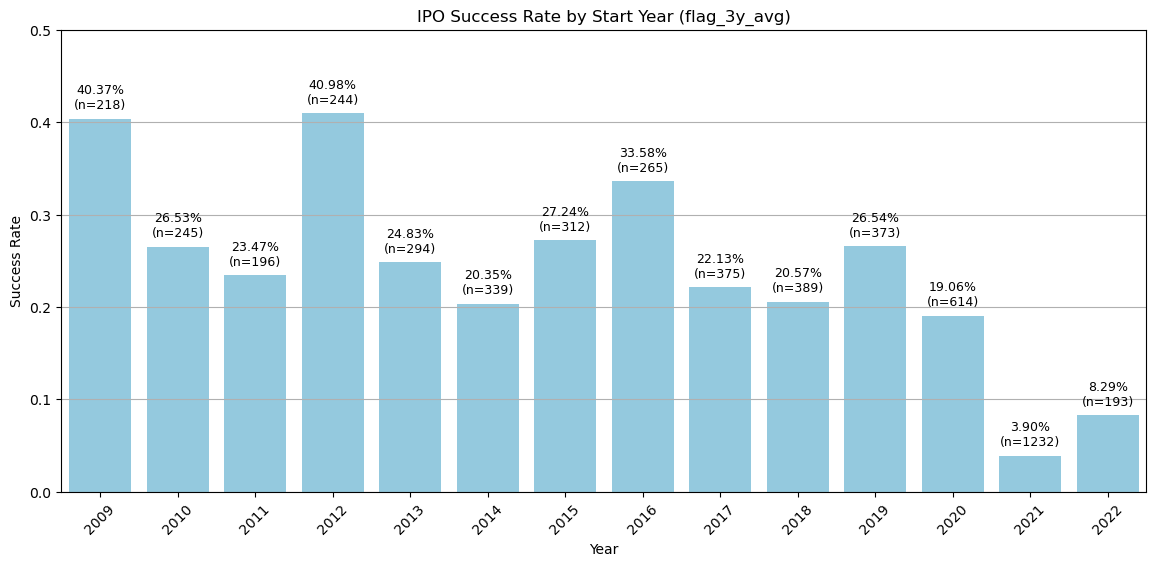

In [10]:
# success rate by month and year(3y)
for flag in ['flag_3y_price', 'flag_3y_avg']:
    print(f"\n📅 Analyzing {flag} by Start Month and Start Year...")

    df_mature = df_clean[df_clean['start_date'] <= three_years_ago]

    month_success = df_clean.groupby('start_month')[flag].agg(['count', 'sum'])
    month_success['success_rate'] = month_success['sum'] / month_success['count']

    plt.figure(figsize=(12,6))
    ax = sns.barplot(x=month_success.index, y=month_success['success_rate'], color='steelblue')
    plt.title(f'IPO Success Rate by Start Month ({flag})')
    plt.xlabel('Month')
    plt.ylabel('Success Rate')
    plt.xticks(ticks=range(0,12), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    plt.ylim(0, 0.3) 
    plt.grid(True, axis='y')

    for i, p in enumerate(ax.patches):
        height = p.get_height()
        count = month_success.iloc[i]['count']
        ax.annotate(f'{height:.2%}\n(n={int(count)})',
                    (p.get_x() + p.get_width()/2., height),
                    ha='center', va='bottom', fontsize=9, color='black', xytext=(0,5),
                    textcoords='offset points')
    plt.show()

    year_success = df_mature.groupby('start_year')[flag].agg(['count', 'sum'])
    year_success['success_rate'] = year_success['sum'] / year_success['count']

    plt.figure(figsize=(14,6))
    ax = sns.barplot(x=year_success.index, y=year_success['success_rate'], color='skyblue')
    plt.title(f'IPO Success Rate by Start Year ({flag})')
    plt.xlabel('Year')
    plt.ylabel('Success Rate')
    plt.xticks(rotation=45)
    plt.ylim(0, 0.5) 
    plt.grid(True, axis='y')

    for i, p in enumerate(ax.patches):
        height = p.get_height()
        count = year_success.iloc[i]['count']
        ax.annotate(f'{height:.2%}\n(n={int(count)})',
                    (p.get_x() + p.get_width()/2., height),
                    ha='center', va='bottom', fontsize=9, color='black', xytext=(0,5),
                    textcoords='offset points')
    plt.show()


Inflation Rate Bin Distribution:
inflation_bin
Low (<2%)        2831
Medium (2-4%)    2018
High (>4%)       1297
Name: count, dtype: int64

IPO Success Rate by Inflation Rate Bin:
               count  sum  success_rate
inflation_bin                          
Low (<2%)       2831  717      0.253267
Medium (2-4%)   2018  492      0.243806
High (>4%)      1297  119      0.091750


C:\Users\User\AppData\Local\Temp\ipykernel_21964\914250240.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_21964\914250240.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



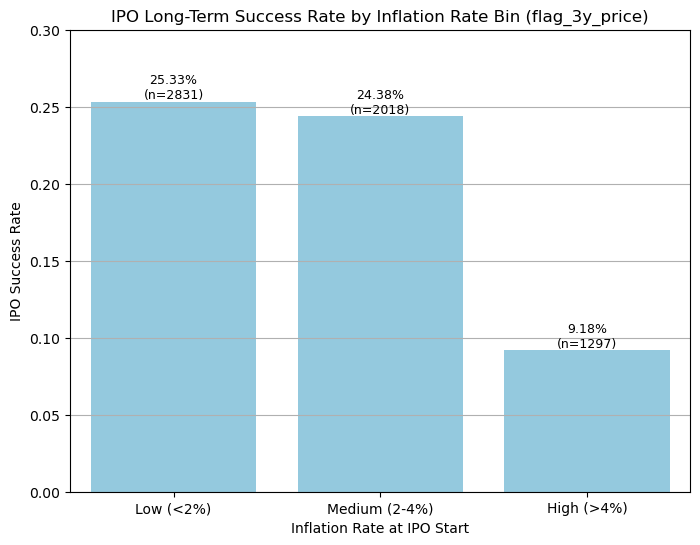

In [11]:
# inlfation rate
inflation_bins = [-float('inf'), 2, 4, float('inf')]  # <2%, 2%-4%, >4%
inflation_labels = ['Low (<2%)', 'Medium (2-4%)', 'High (>4%)']

df_clean['inflation_bin'] = pd.cut(
    df_clean['inflation_rate_at_start'],
    bins=inflation_bins,
    labels=inflation_labels
)

print("\nInflation Rate Bin Distribution:")
print(df_clean['inflation_bin'].value_counts())

inflation_success = df_clean.groupby('inflation_bin')['flag_3y_price'].agg(['count', 'sum'])
inflation_success['success_rate'] = inflation_success['sum'] / inflation_success['count']

print("\nIPO Success Rate by Inflation Rate Bin:")
print(inflation_success)

plt.figure(figsize=(8,6))
sns.barplot(x=inflation_success.index, y=inflation_success['success_rate'], color='skyblue')
plt.title('IPO Long-Term Success Rate by Inflation Rate Bin (flag_3y_price)')
plt.xlabel('Inflation Rate at IPO Start')
plt.ylabel('IPO Success Rate')
plt.ylim(0, 0.3)
plt.grid(True, axis='y')

# Add labels on bars
for i, p in enumerate(plt.gca().patches):
    height = p.get_height()
    count = inflation_success.iloc[i]['count']
    plt.text(
        p.get_x() + p.get_width()/2., height,
        f'{height:.2%}\n(n={int(count)})',
        ha='center', va='bottom', fontsize=9, color='black'
    )

plt.show()


📊 IPO Success Rate by Fed Funds Rate Bin — flag_6m_price
               count   sum  success_rate
fed_funds_bin                           
Low (<1%)       4248  1331      0.313324
Medium (1-3%)   1187   369      0.310868
High (>3%)       711   225      0.316456


C:\Users\User\AppData\Local\Temp\ipykernel_21964\3676237861.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_21964\3676237861.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



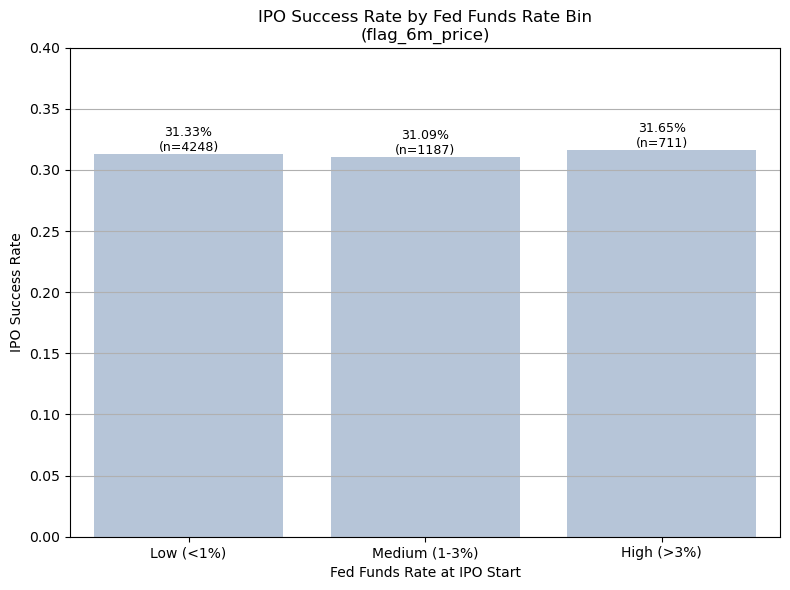


📊 IPO Success Rate by Fed Funds Rate Bin — flag_6m_avg
               count   sum  success_rate
fed_funds_bin                           
Low (<1%)       4248  1349      0.317561
Medium (1-3%)   1187   382      0.321820
High (>3%)       711   223      0.313643


C:\Users\User\AppData\Local\Temp\ipykernel_21964\3676237861.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



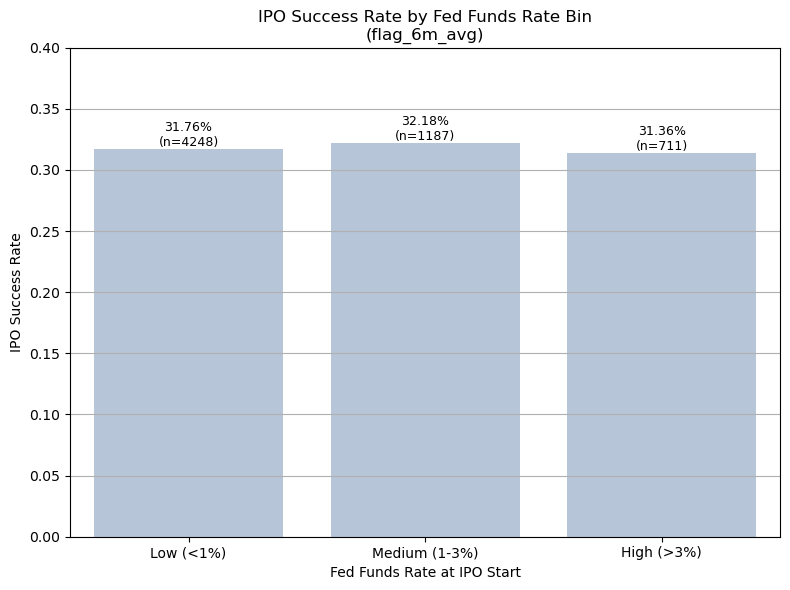


📊 IPO Success Rate by Fed Funds Rate Bin — flag_3y_price
               count  sum  success_rate
fed_funds_bin                          
Low (<1%)       4248  892      0.209981
Medium (1-3%)   1187  281      0.236731
High (>3%)       711  155      0.218003


C:\Users\User\AppData\Local\Temp\ipykernel_21964\3676237861.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



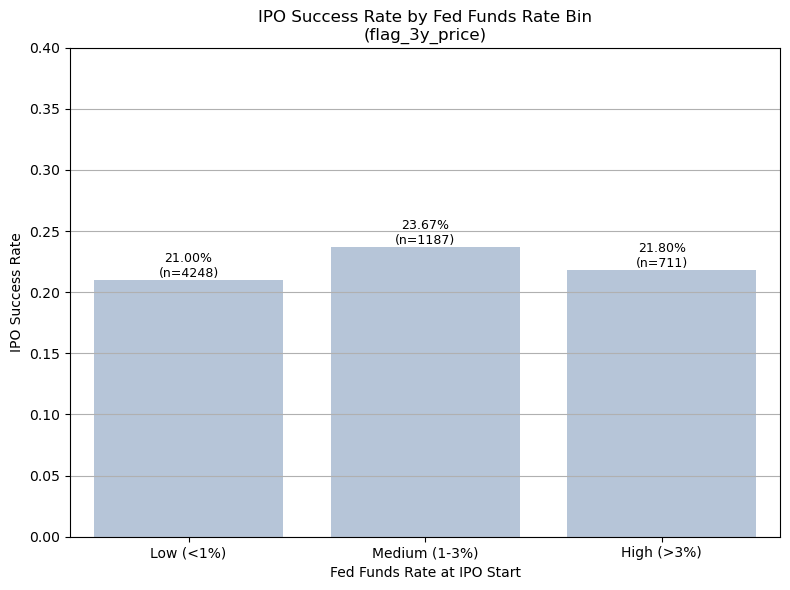


📊 IPO Success Rate by Fed Funds Rate Bin — flag_3y_avg
               count  sum  success_rate
fed_funds_bin                          
Low (<1%)       4248  818      0.192561
Medium (1-3%)   1187  257      0.216512
High (>3%)       711  140      0.196906


C:\Users\User\AppData\Local\Temp\ipykernel_21964\3676237861.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



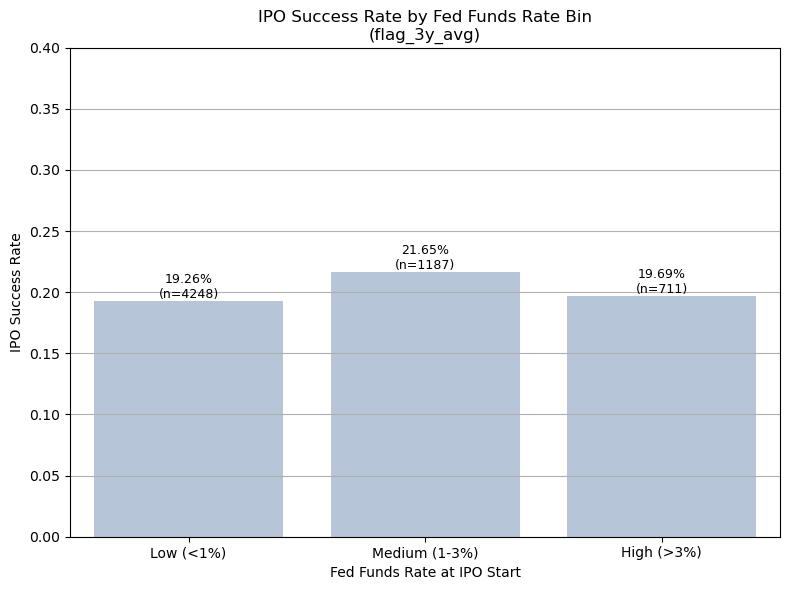

In [12]:
# fed funds rate
fed_bins = [-float('inf'), 1, 3, float('inf')] 
fed_labels = ['Low (<1%)', 'Medium (1-3%)', 'High (>3%)']
df_clean['fed_funds_bin'] = pd.cut(df_clean['fed_funds_rate_at_start'], bins=fed_bins, labels=fed_labels)

success_indicators = ['flag_6m_price', 'flag_6m_avg', 'flag_3y_price', 'flag_3y_avg']

for flag in success_indicators:
    print(f"\n📊 IPO Success Rate by Fed Funds Rate Bin — {flag}")
    
    fed_success = df_clean.groupby('fed_funds_bin')[flag].agg(['count', 'sum'])
    fed_success['success_rate'] = fed_success['sum'] / fed_success['count']
    
    print(fed_success)

    plt.figure(figsize=(8,6))
    sns.barplot(x=fed_success.index, y=fed_success['success_rate'], color='lightsteelblue')
    plt.title(f'IPO Success Rate by Fed Funds Rate Bin\n({flag})')
    plt.xlabel('Fed Funds Rate at IPO Start')
    plt.ylabel('IPO Success Rate')
    plt.ylim(0, 0.4) 
    plt.grid(True, axis='y')

    for i, p in enumerate(plt.gca().patches):
        height = p.get_height()
        count = fed_success.iloc[i]['count']
        plt.text(p.get_x() + p.get_width()/2., height,
                 f'{height:.2%}\n(n={int(count)})',
                 ha='center', va='bottom', fontsize=9, color='black')

    plt.tight_layout()
    plt.show()




📈 Analyzing S&P 500 SMA30 Position...

➡ Success Indicator: flag_6m_price
                      count   sum  success_rate
sp500_SMA30_position                           
Above SMA30            3564  1038      0.291246
Below SMA30            2570   883      0.343580


C:\Users\User\AppData\Local\Temp\ipykernel_21964\2208436720.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



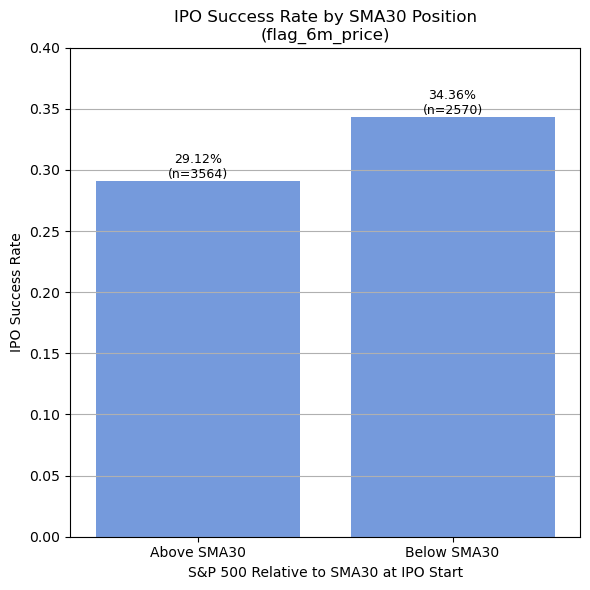

➡ Success Indicator: flag_6m_avg
                      count   sum  success_rate
sp500_SMA30_position                           
Above SMA30            3564  1052      0.295174
Below SMA30            2570   898      0.349416


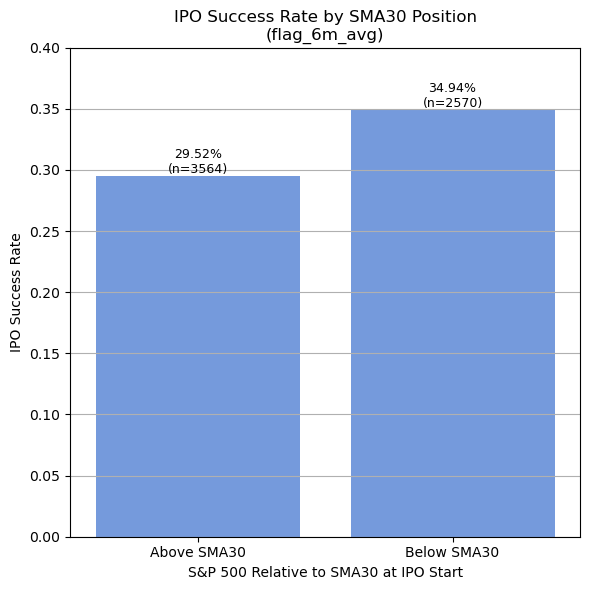

➡ Success Indicator: flag_3y_price
                      count  sum  success_rate
sp500_SMA30_position                          
Above SMA30            3564  758      0.212682
Below SMA30            2570  569      0.221401


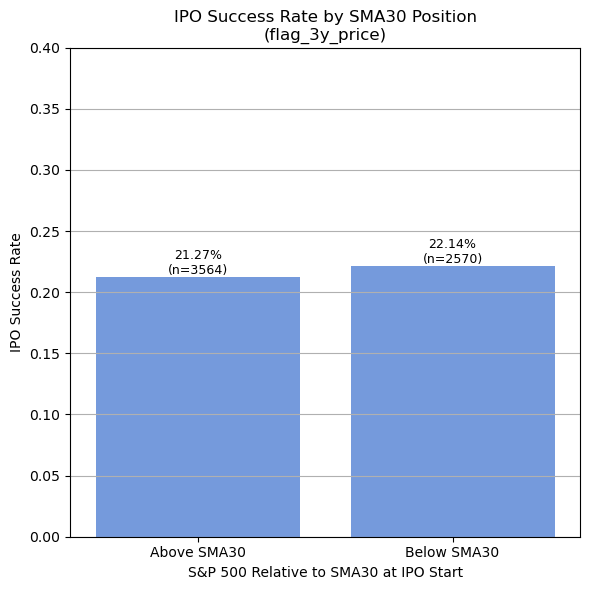

➡ Success Indicator: flag_3y_avg
                      count  sum  success_rate
sp500_SMA30_position                          
Above SMA30            3564  684      0.191919
Below SMA30            2570  531      0.206615


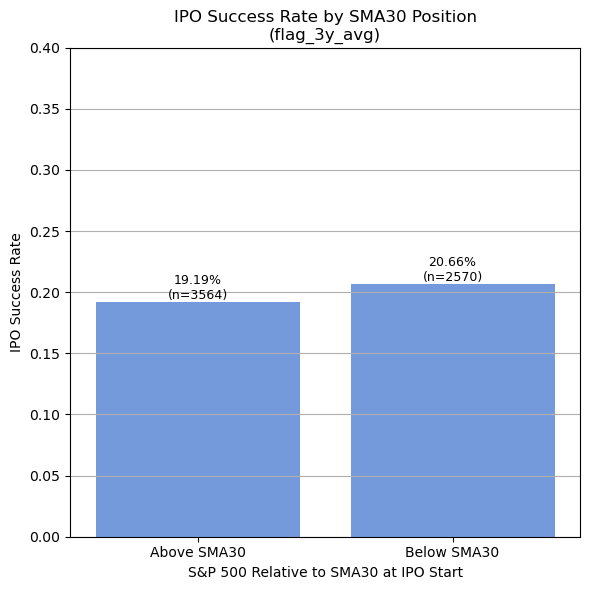


📈 Analyzing S&P 500 SMA50 Position...

➡ Success Indicator: flag_6m_price
                      count   sum  success_rate
sp500_SMA50_position                           
Above SMA50            4640  1412      0.304310
Below SMA50            1506   513      0.340637


C:\Users\User\AppData\Local\Temp\ipykernel_21964\2208436720.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



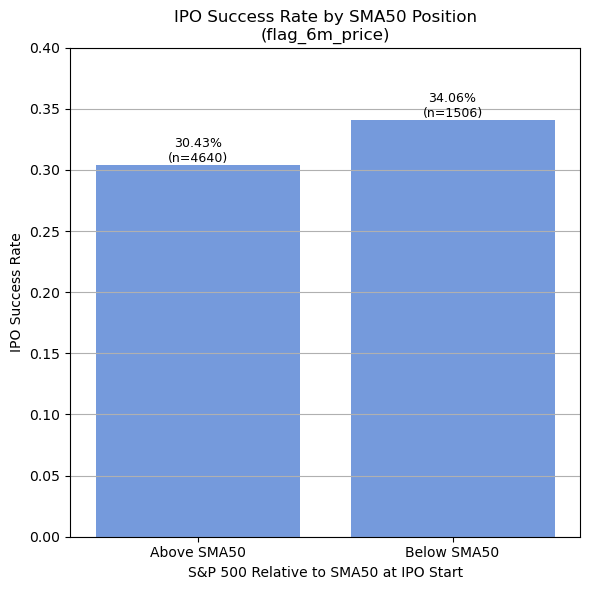

➡ Success Indicator: flag_6m_avg
                      count   sum  success_rate
sp500_SMA50_position                           
Above SMA50            4640  1433      0.308836
Below SMA50            1506   521      0.345950


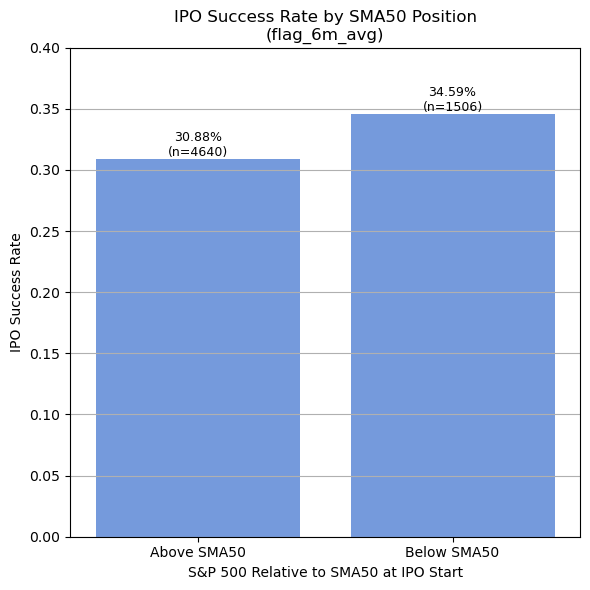

➡ Success Indicator: flag_3y_price
                      count  sum  success_rate
sp500_SMA50_position                          
Above SMA50            4640  941      0.202802
Below SMA50            1506  387      0.256972


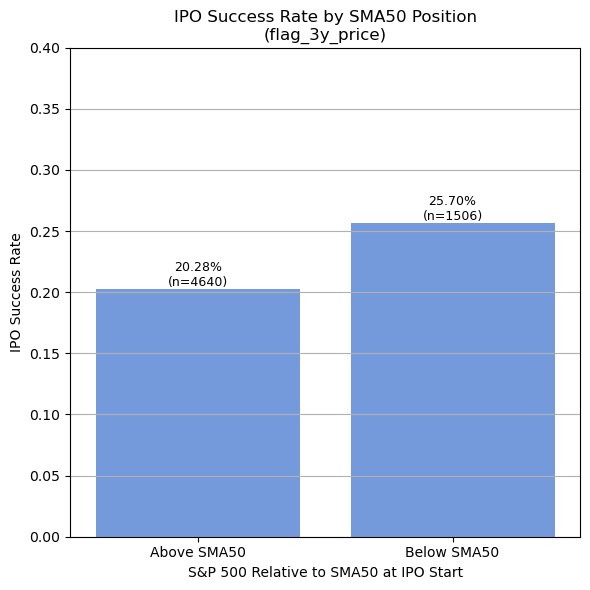

➡ Success Indicator: flag_3y_avg
                      count  sum  success_rate
sp500_SMA50_position                          
Above SMA50            4640  873      0.188147
Below SMA50            1506  342      0.227092


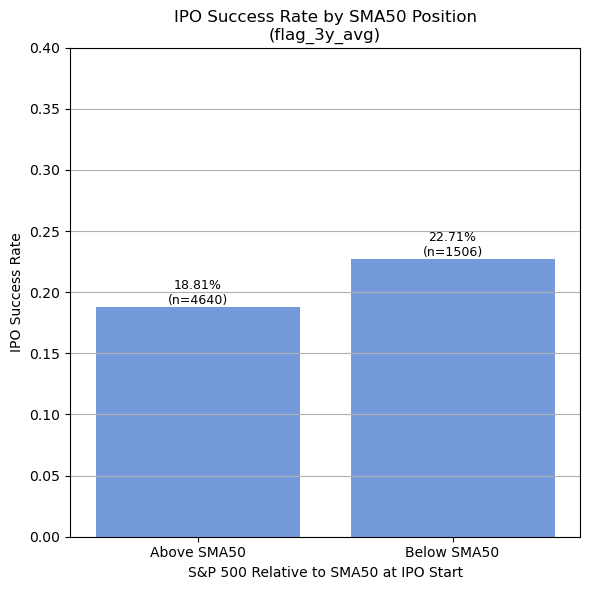


📈 Analyzing S&P 500 SMA200 Position...

➡ Success Indicator: flag_6m_price
                       count   sum  success_rate
sp500_SMA200_position                           
Above SMA200            5331  1623      0.304446
Below SMA200             815   302      0.370552


C:\Users\User\AppData\Local\Temp\ipykernel_21964\2208436720.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



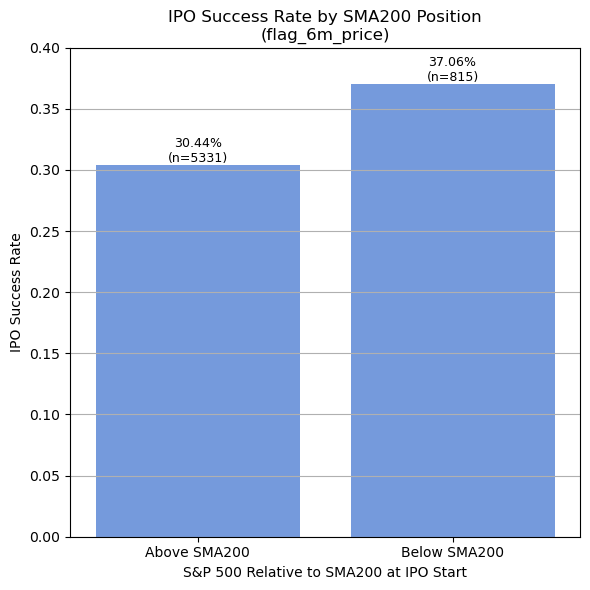

➡ Success Indicator: flag_6m_avg
                       count   sum  success_rate
sp500_SMA200_position                           
Above SMA200            5331  1650      0.309510
Below SMA200             815   304      0.373006


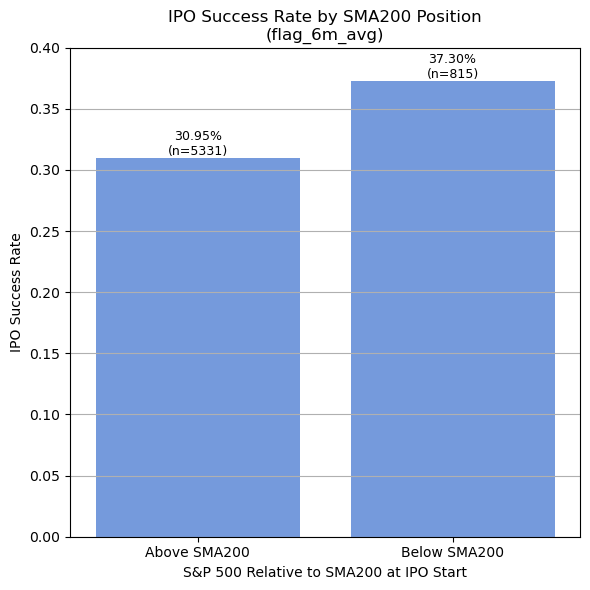

➡ Success Indicator: flag_3y_price
                       count   sum  success_rate
sp500_SMA200_position                           
Above SMA200            5331  1099      0.206153
Below SMA200             815   229      0.280982


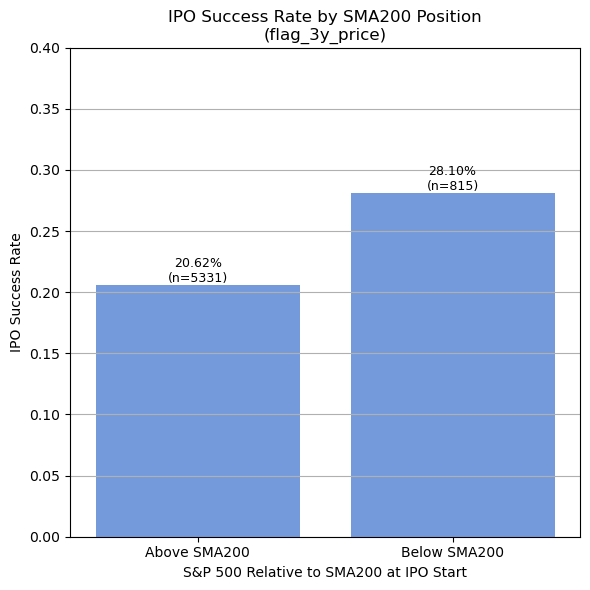

➡ Success Indicator: flag_3y_avg
                       count   sum  success_rate
sp500_SMA200_position                           
Above SMA200            5331  1013      0.190021
Below SMA200             815   202      0.247853


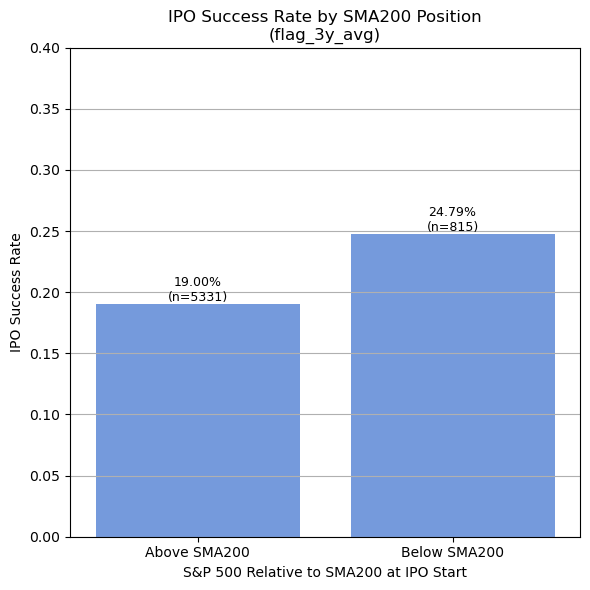

In [13]:
# S&P500
sma_features = {
    'sp500_above_30sma_centered': 'SMA30',
    'sp500_above_50sma': 'SMA50',
    'sp500_above_200sma': 'SMA200'
}

success_indicators = [
    'flag_6m_price',
    'flag_6m_avg',
    'flag_3y_price',
    'flag_3y_avg'
]

for sma_feature, sma_label in sma_features.items():
    print(f"\n📈 Analyzing S&P 500 {sma_label} Position...\n")

    position_col = f'sp500_{sma_label}_position'
    df_clean[position_col] = df_clean[sma_feature].map({True: f'Above {sma_label}', False: f'Below {sma_label}'})

    for flag in success_indicators:
        print(f"➡ Success Indicator: {flag}")

        sma_success = df_clean.groupby(position_col)[flag].agg(['count', 'sum'])
        sma_success['success_rate'] = sma_success['sum'] / sma_success['count']

        print(sma_success)

        plt.figure(figsize=(6,6))
        sns.barplot(x=sma_success.index, y=sma_success['success_rate'], color='cornflowerblue')
        plt.title(f'IPO Success Rate by {sma_label} Position\n({flag})')
        plt.xlabel(f'S&P 500 Relative to {sma_label} at IPO Start')
        plt.ylabel('IPO Success Rate')
        plt.ylim(0, 0.4)
        plt.grid(True, axis='y')

        for i, p in enumerate(plt.gca().patches):
            height = p.get_height()
            count = sma_success.iloc[i]['count']
            plt.text(p.get_x() + p.get_width()/2., height,
                     f'{height:.2%}\n(n={int(count)})',
                     ha='center', va='bottom', fontsize=9, color='black')

        plt.tight_layout()
        plt.show()



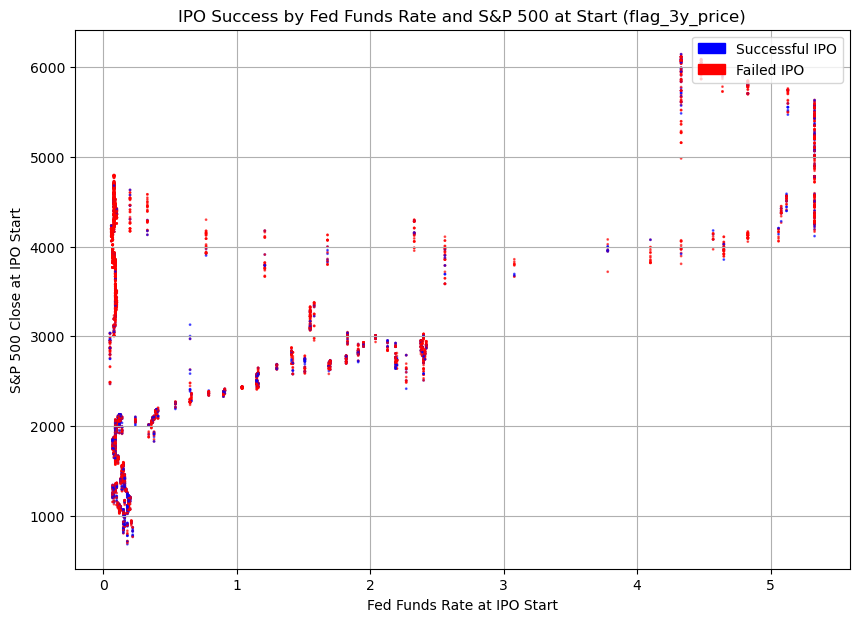

In [14]:
# scatter plot fed funds rate vs s&p500
color_map = {1: 'blue', 0: 'red'}

colors = df_clean['flag_3y_price'].map(color_map)

plt.figure(figsize=(10,7))
plt.scatter(
    df_clean['fed_funds_rate_at_start'], 
    df_clean['sp500_close_at_start'], 
    c=colors,
    alpha=0.6,
    s=1
)

plt.title('IPO Success by Fed Funds Rate and S&P 500 at Start (flag_3y_price)')
plt.xlabel('Fed Funds Rate at IPO Start')
plt.ylabel('S&P 500 Close at IPO Start')
plt.grid(True)

import matplotlib.patches as mpatches
success_patch = mpatches.Patch(color='blue', label='Successful IPO')
failure_patch = mpatches.Patch(color='red', label='Failed IPO')
plt.legend(handles=[success_patch, failure_patch], loc='upper right')

plt.show()


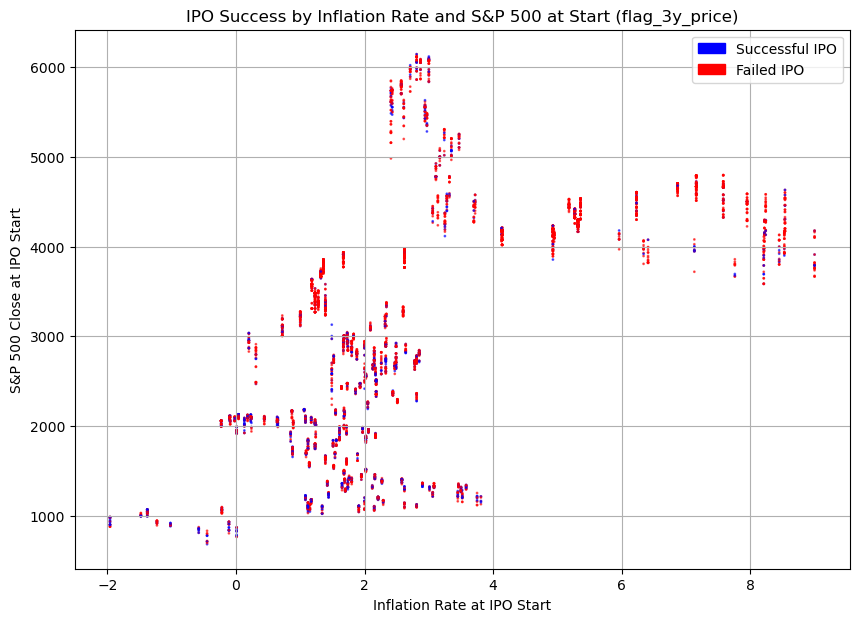

In [15]:
# scatter plot inlfation rate vs s&p500
color_map = {1: 'blue', 0: 'red'}

colors = df_clean['flag_3y_price'].map(color_map)

plt.figure(figsize=(10,7))
plt.scatter(
    df_clean['inflation_rate_at_start'], 
    df_clean['sp500_close_at_start'], 
    c=colors,
    alpha=0.6,
    s=1
)

plt.title('IPO Success by Inflation Rate and S&P 500 at Start (flag_3y_price)')
plt.xlabel('Inflation Rate at IPO Start')
plt.ylabel('S&P 500 Close at IPO Start')
plt.grid(True)

import matplotlib.patches as mpatches
success_patch = mpatches.Patch(color='blue', label='Successful IPO')
failure_patch = mpatches.Patch(color='red', label='Failed IPO')
plt.legend(handles=[success_patch, failure_patch], loc='upper right')

plt.show()

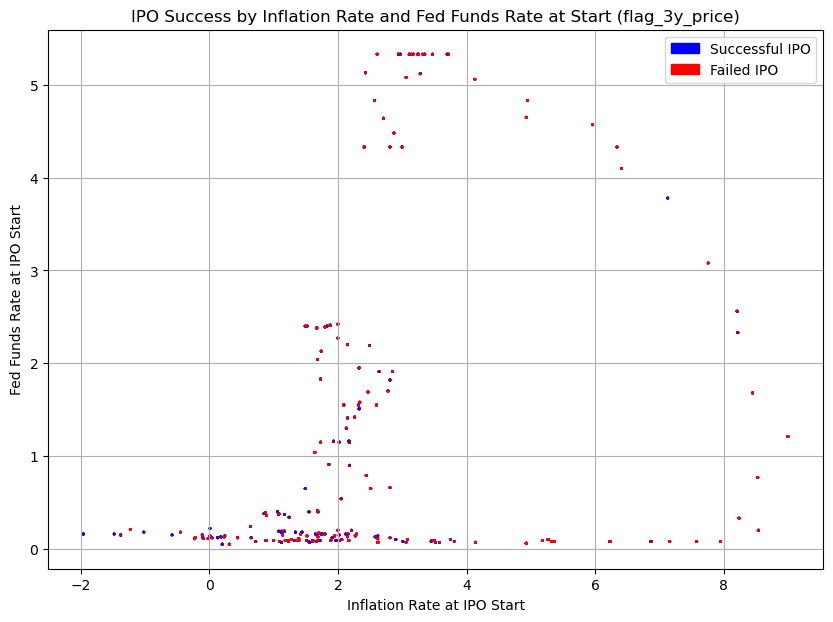

In [16]:
# scatter plot inflation rate vs fed funds rate
color_map = {1: 'blue', 0: 'red'}

colors = df_clean['flag_3y_price'].map(color_map)

plt.figure(figsize=(10,7))
plt.scatter(
    df_clean['inflation_rate_at_start'], 
    df_clean['fed_funds_rate_at_start'], 
    c=colors,
    alpha=0.6,
    s=1
)

plt.title('IPO Success by Inflation Rate and Fed Funds Rate at Start (flag_3y_price)')
plt.xlabel('Inflation Rate at IPO Start')
plt.ylabel('Fed Funds Rate at IPO Start')
plt.grid(True)

import matplotlib.patches as mpatches
success_patch = mpatches.Patch(color='blue', label='Successful IPO')
failure_patch = mpatches.Patch(color='red', label='Failed IPO')
plt.legend(handles=[success_patch, failure_patch], loc='upper right')

plt.show()


SIC Descriptions by IPO Success Rate (min 50 IPOs):
                                                    count  sum  success_rate
sic_description                                                             
Commodity Contracts Brokers & Dealers                  59   25      0.423729
Gold and Silver Ores                                   57   23      0.403509
Medicinal Chemicals & Botanical Products               54   16      0.296296
Crude Petroleum & Natural Gas                          85   25      0.294118
Semiconductors & Related Devices                       62   17      0.274194
Services-Prepackaged Software                         305   82      0.268852
Services-Business Services, NEC                       133   34      0.255639
Metal Mining                                           55   14      0.254545
Services-Computer Processing & Data Preparation       107   27      0.252336
State Commercial Banks                                 88   21      0.238636
Real Estate Investment 

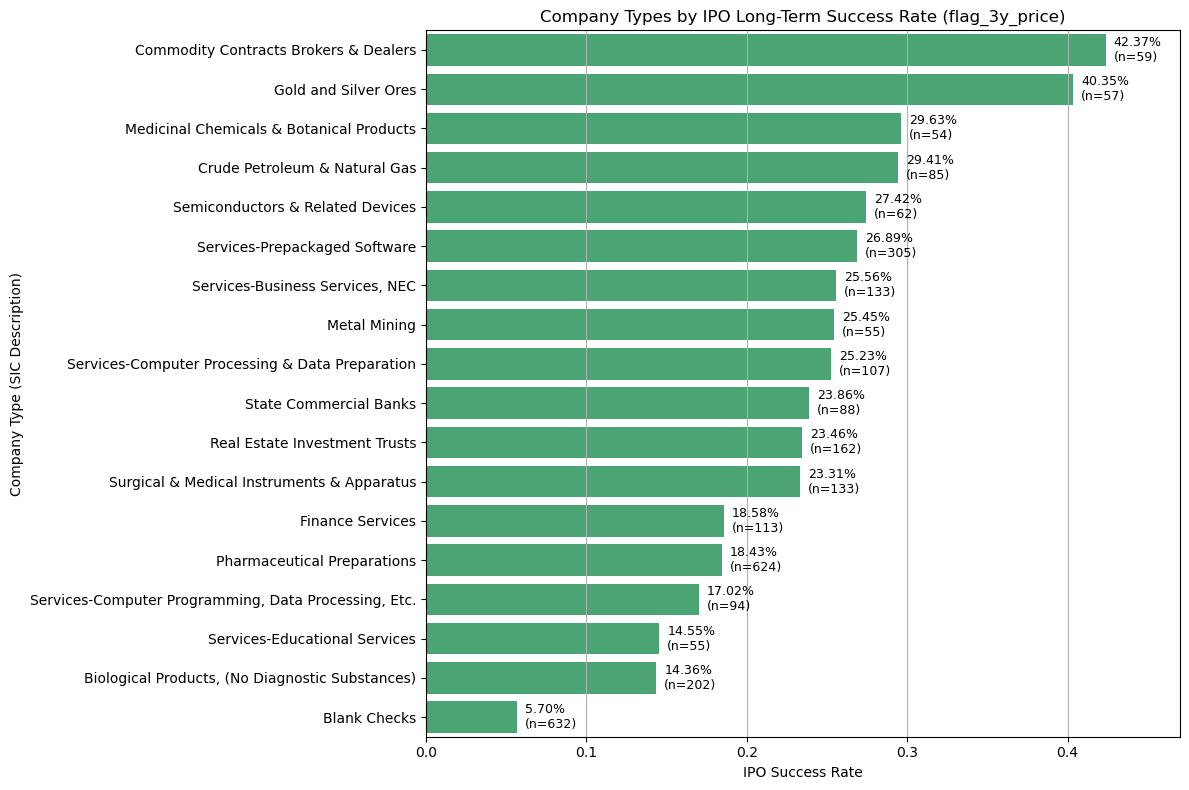

In [24]:
# Success rate by company type(sample size > 50)
df_valid = df[(df['flag_3y_price'].notnull()) & (df['sic_description'].notnull())]

sic_success = df_valid.groupby('sic_description')['flag_3y_price'].agg(['count', 'sum'])
sic_success['success_rate'] = sic_success['sum'] / sic_success['count']

sic_success_filtered = sic_success[sic_success['count'] >= 50].sort_values(by='success_rate', ascending=False)

print("\nSIC Descriptions by IPO Success Rate (min 50 IPOs):")
print(sic_success_filtered.head(18))

plt.figure(figsize=(12, 8))
top_n = sic_success_filtered.head(18).reset_index()
sns.barplot(data=top_n, y='sic_description', x='success_rate', color='mediumseagreen')
plt.title('Company Types by IPO Long-Term Success Rate (flag_3y_price)')
plt.xlabel('IPO Success Rate')
plt.ylabel('Company Type (SIC Description)')
plt.grid(True, axis='x')
plt.xlim(0, 0.47)

for i, row in top_n.iterrows():
    plt.text(row['success_rate'] + 0.005, i, f"{row['success_rate']:.2%}\n(n={int(row['count'])})", 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()


SIC Descriptions by IPO Success Rate (min 50 IPOs):
                                                 count  sum  success_rate
sic_description                                                          
Commodity Contracts Brokers & Dealers               59   25      0.423729
Gold and Silver Ores                                57   23      0.403509
Medicinal Chemicals & Botanical Products            54   16      0.296296
Crude Petroleum & Natural Gas                       85   25      0.294118
Semiconductors & Related Devices                    62   17      0.274194
Services-Prepackaged Software                      305   82      0.268852
Services-Business Services, NEC                    133   34      0.255639
Metal Mining                                        55   14      0.254545
Services-Computer Processing & Data Preparation    107   27      0.252336
State Commercial Banks                              88   21      0.238636


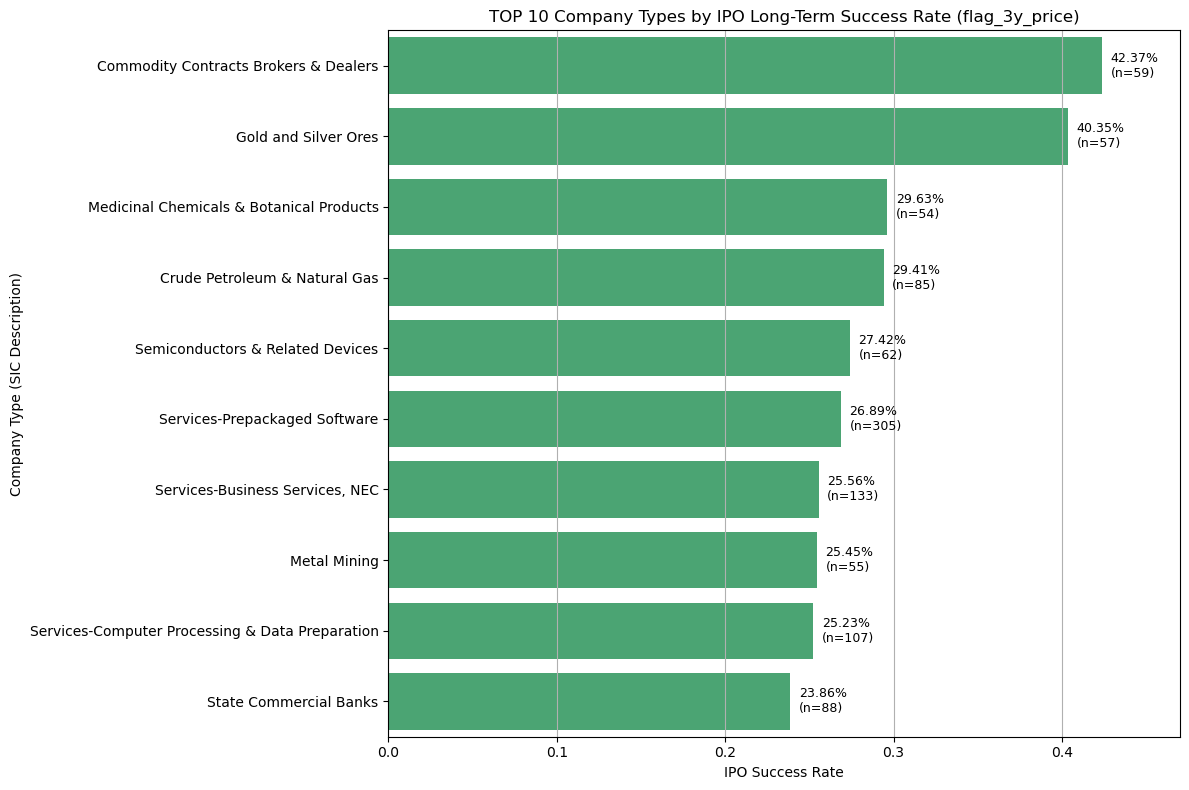

In [25]:
# Success rate by company type(sample size > 50)
df_valid = df[(df['flag_3y_price'].notnull()) & (df['sic_description'].notnull())]

sic_success = df_valid.groupby('sic_description')['flag_3y_price'].agg(['count', 'sum'])
sic_success['success_rate'] = sic_success['sum'] / sic_success['count']

sic_success_filtered = sic_success[sic_success['count'] >= 50].sort_values(by='success_rate', ascending=False)

print("\nSIC Descriptions by IPO Success Rate (min 50 IPOs):")
print(sic_success_filtered.head(10))

plt.figure(figsize=(12, 8))
top_n = sic_success_filtered.head(10).reset_index()
sns.barplot(data=top_n, y='sic_description', x='success_rate', color='mediumseagreen')
plt.title('TOP 10 Company Types by IPO Long-Term Success Rate (flag_3y_price)')
plt.xlabel('IPO Success Rate')
plt.ylabel('Company Type (SIC Description)')
plt.grid(True, axis='x')
plt.xlim(0, 0.47)

for i, row in top_n.iterrows():
    plt.text(row['success_rate'] + 0.005, i, f"{row['success_rate']:.2%}\n(n={int(row['count'])})", 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [18]:
# SIC descriptions
unique_sic_count = df['sic_description'].nunique()
print(f"📊 Total unique company types (SIC Descriptions): {unique_sic_count}")

sic_counts = df['sic_description'].value_counts()
print("\n🔝 Top 10 most common company types:")
print(sic_counts.head(10))

sic_over_50 = (sic_counts >= 50).sum()
print(f"\n✅ Number of company types with ≥ 50 IPOs: {sic_over_50}")


📊 Total unique company types (SIC Descriptions): 364

🔝 Top 10 most common company types:
sic_description
Blank Checks                                            632
Pharmaceutical Preparations                             624
Services-Prepackaged Software                           305
Biological Products, (No Diagnostic Substances)         202
Real Estate Investment Trusts                           162
Surgical & Medical Instruments & Apparatus              133
Services-Business Services, NEC                         133
Finance Services                                        113
Services-Computer Processing & Data Preparation         107
Services-Computer Programming, Data Processing, Etc.     94
Name: count, dtype: int64

✅ Number of company types with ≥ 50 IPOs: 18
